# Save COVID-19 PDFs for San Diego County

### Modules

In [1]:
import os
import requests
#from datetime import date
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
# PDF processing module
import camelot
import PyPDF2

### Import Lastest COVID-19 Ethinicity csv

In [2]:
df = pd.read_csv('SD_Ethnicity-COVID-Cases_Cumulated.csv')

### Define a function to plot daily infected cases from cumulative data

In [3]:
# This function can take culmulative infected cases as input and plot daily infected cases and its moving average

def plot_daily_case(selected_list, df, t_ma, plt_title, path, pdf_date): 
    # df_sel --- filter out df based on selected_list
    df_sel = df.loc[df[df.columns[0]].isin(selected_list)]
    

    # create numpy array to process data, excluding ethnicity columns
    sel_np = np.array(df_sel.iloc[:,1:])

    # process negative increased cases 11-13-12 ==> 11 12 12
    for i in list(range(0, sel_np.shape[0])):
            for j in list(range(sel_np.shape[1]-1,0,-1)):
                if sel_np[i][j] < sel_np[i][j-1]:
                    sel_np[i][j-1] = sel_np[i][j]              

    # Averaged total daily increased number of cases in the ethnicity group
    sel_np_total = sel_np.mean(axis=0)
    # all_np -- sel_np with 'total' row
    all_np = np.row_stack((sel_np,sel_np_total))
    
    # calculate the number of increased cases in each day
    # number of increased cases in (n)th day = data[n+1]-data[n]
    np_temp = np.full(all_np.shape, 0, dtype=float)
    np_temp[:, 0:-1] = all_np[:,1:]
    np_slope_inst = np_temp - all_np
    # excluding the last date
    np_slope_inst = np_slope_inst[:,0:-1]
    
    # calculate moving average
    np_ma = np.cumsum(np_slope_inst, dtype=float, axis=1)
    np_ma[:,t_ma:] = np_ma[:,t_ma:] - np_ma[:,:-t_ma]
    np_slope_ave = np_ma[:,t_ma - 1:] / t_ma
    
    # dataframe with total row
    df_all = df_sel.append({'Ethnicity' : 'Average'}, ignore_index = True)
    
    # Save daily increased cases in a separate dataframe
    df_all_inst = df_all.copy()
    df_all_inst.iloc[:,(int(1/2)+1):-(int(1/2)+1)] = np_slope_inst
    col_drop_inst = list(range(1,(int(1/2)+1))) + list(range((-(int(1/2)+1)),0))
    df_all_inst = df_all_inst.drop(df_all_inst.columns[col_drop_inst], axis=1)
    
    # put numpy with total row back to df_all
    # number of columns in df_all to be replaced depends on whether the moving window size is even or odd
    if (t_ma % 2) == 0:
        df_all.iloc[:,(int(t_ma/2)+1):-(int(t_ma/2))] = np_slope_ave
        col_drop = list(range(1,(int(t_ma/2)+1))) + list(range((-(int(t_ma/2))),0))
    else:
        df_all.iloc[:,(int(t_ma/2)+1):-(int(t_ma/2)+1)] = np_slope_ave
        col_drop = list(range(1,(int(t_ma/2)+1))) + list(range((-(int(t_ma/2)+1)),0))

    # drop the first and last t_ma/2 columns
    df_all = df_all.drop(df_all.columns[col_drop], axis=1)
    
    # plot 
    df_header = list(df_all.columns)[1:]
    df_header_dates = [dt.datetime.strptime(i,'%m/%d/%y') for i in df_header]
    df_header_inst = list(df_all_inst.columns)[1:]
    df_header_dates_inst = [dt.datetime.strptime(i,'%m/%d/%y') for i in df_header_inst]
    fig, ax = plt.subplots(figsize=(15,10))
    
    # create proper legend
    selected_list_str = list(df_all['Ethnicity'])
    selected_list_str = selected_list_str[:-2]
    selected_list_str = [val for val in selected_list_str for _ in (0, 1)]
    for i in range(len(selected_list_str)):
        if i%2 == 0:
            selected_list_str[i] = selected_list_str[i] + ', T=7'
    
    colors = ['#014182', '#be6400', 'tab:grey', '#f9bc08', '#75bbfd', 'tab:green', '#f36196']
    # In the plot, unknown ethnicity group and average data are not plotted
    for i in range(df_all.shape[0]-2):
        ax.plot(df_header_dates, df_all.iloc[i,1:], '-', linewidth=2.0, c=colors[i])
        ax.plot(df_header_dates_inst, df_all_inst.iloc[i,1:], '--', linewidth=0.2, color=plt.gca().lines[-1].get_color())
    
    ax.set_xlabel('Date', fontsize=15)
    ax.set_ylabel(f'Daily Increased Cases', fontsize=15)
    plt.title(plt_title, fontsize=20)
    lgd = plt.legend(selected_list_str*2, bbox_to_anchor=(1.25, 1), fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%m-%d"))
    plt.grid(linestyle='--')
    #plt.show()
    fig.savefig(path + '/' + plt_title + '_' + pdf_date.replace('/','') + '.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
    

### Main

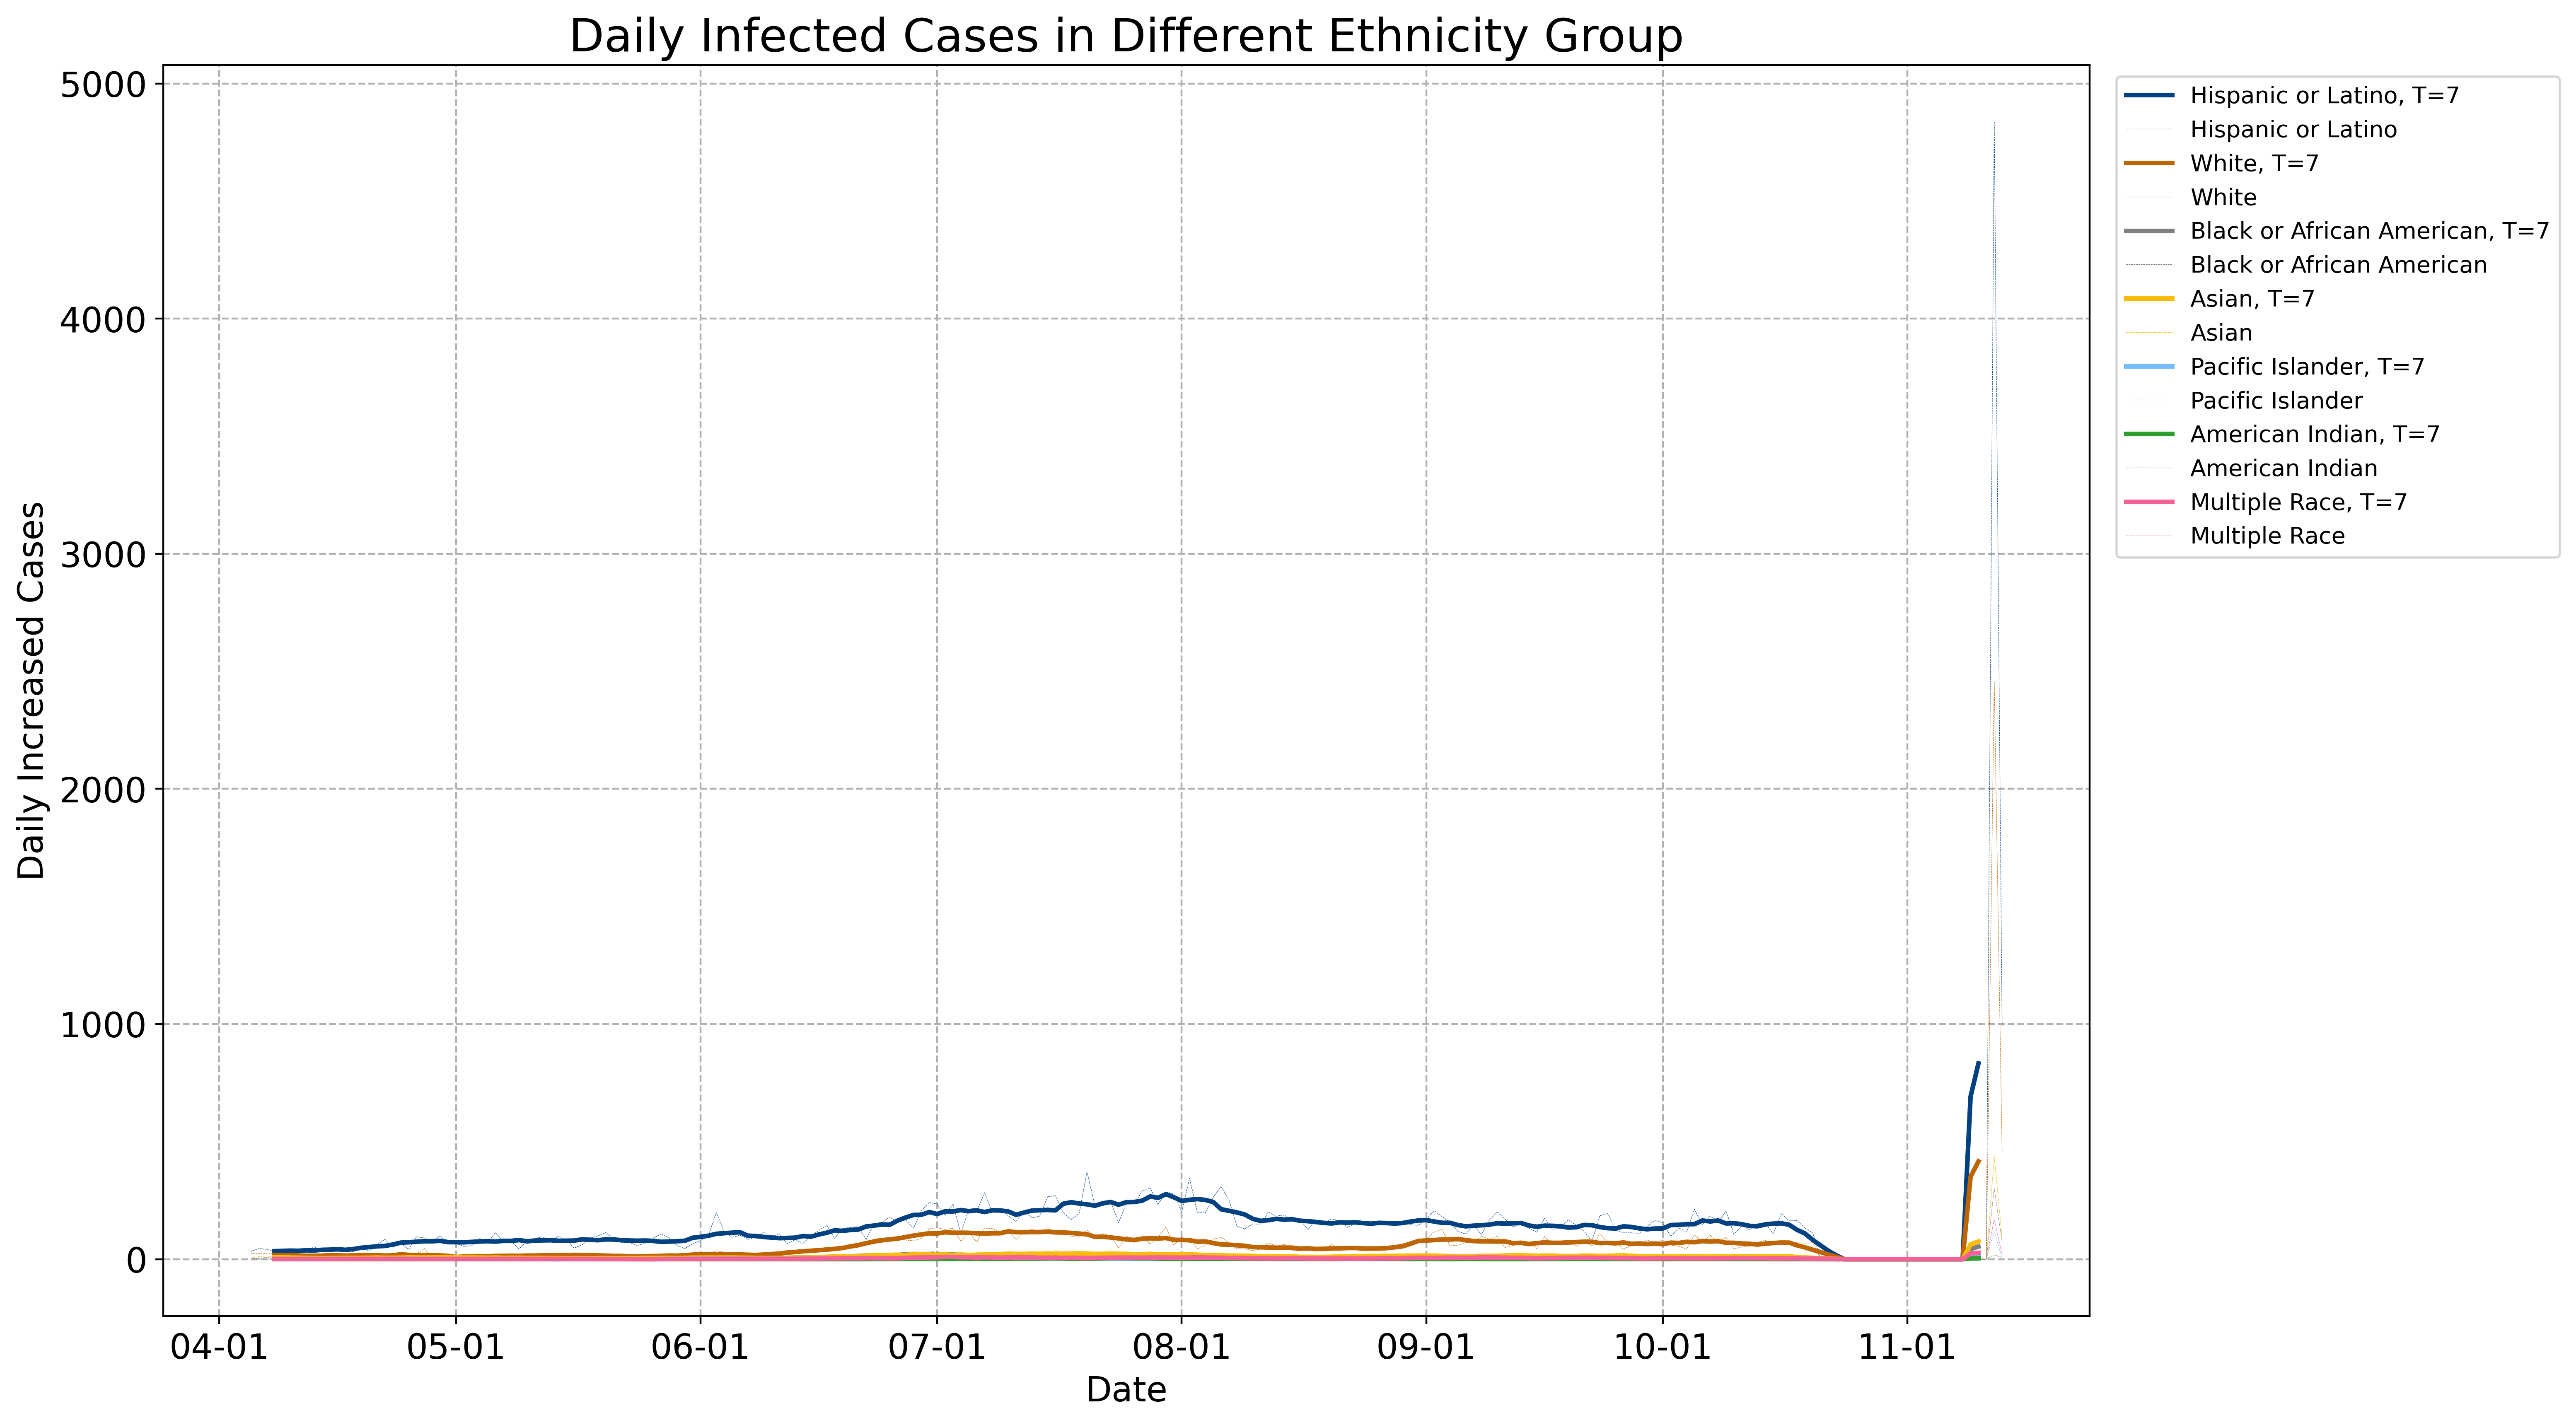

In [4]:
# Create today's folder to store pdf if it doesn't exist
most_recent_date = dt.date.today().strftime("%m/%d/%Y")
path = 'C://Users/mshRu/Dropbox/SD-COVID19-Statistic-Models-Shared/Time-Series-Analysis-Yuan/SD_Ethnicity_COVID_Cases/{}'.format(most_recent_date.replace('/', ''))
if not os.path.exists(path):
    os.makedirs(path)
    
# Save pdf to today's folder
url = 'https://www.sandiegocounty.gov/content/dam/sdc/hhsa/programs/phs/Epidemiology/COVID-19%20Race%20and%20Ethnicity%20Summary.pdf'
response = requests.get(url)
with open(path + '/' + 'COVID-19%20Race%20and%20Ethnicity%20Summary.pdf'.replace('%20', ' '), 'wb') as f:
    f.write(response.content)
    
# Open the latest pdf and check date
pdf_path = path + '/' + 'COVID-19%20Race%20and%20Ethnicity%20Summary.pdf'.replace('%20', ' ')
text = PyPDF2.PdfFileReader(pdf_path).getPage(0).extractText()
start = text.find("Data through ") + len("Data through ")
end = text.find(", updated")
pdf_date = text[start:end].replace('\n', '').replace('2020','20')

# If the date in pdf is different from the latest date in current csv, then add the data
df_date = list(df.columns)[-1]
if df_date != pdf_date:
    mypdf = camelot.read_pdf(pdf_path)
    df_pdf = mypdf[0].df
    new_data = list(df_pdf.iloc[3:,1])
    del new_data[-2]
    for i in range(len(new_data)):
        new_data[i] = int(new_data[i].replace(',',''))
    new_df = df.copy()
    new_df.insert(len(df.columns),pdf_date,new_data)
    new_df.to_csv(path + '/' + 'SD_Ethnicity-COVID-Cases_Cumulated_' + pdf_date.replace('/','') + '.csv', index=False)
    new_df.to_csv('SD_Ethnicity-COVID-Cases_Cumulated.csv', index=False)
    plot_daily_case(new_df.iloc[:,0], new_df, 7, 'Daily Infected Cases in Different Ethnicity Group', path, pdf_date)